In [1]:
import datetime as dt
import numpy as np
import os
import math
import pandas as pd
import netCDF4
import matplotlib.pyplot as plt
%matplotlib inline

from netCDF4 import num2date
from astral import LocationInfo
from astral.sun import sun
from functions import *

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Reshape

Zmiana formatu danych z netCDF na Pandas DataFrame:

In [2]:
def netCDF2df (filename):
    f = netCDF4.Dataset(filename)
    var_names = ['t2m', 'd2m', 'msl', 'tp', 'u10', 'v10', 'u100', 'v100', 'ssrd'] #100m u,v and ssrd data for evalutation
    variables = {key: f.variables[key][:].flatten() for key in var_names} # dictionary of variable name and data, already flattened for pd
    
    # Extract variable - każdy parametr ma przypisane time, lat, lon
    t2m = f.variables['t2m']
    # Get dimensions assuming 3D: time, latitude, longitude
    time_dim, lat_dim, lon_dim = t2m.get_dims()
    time_var = f.variables[time_dim.name]
    times = num2date(time_var[:], time_var.units, only_use_cftime_datetimes=False, only_use_python_datetimes=True)
    latitudes = f.variables[lat_dim.name][:]
    longitudes = f.variables[lon_dim.name][:]
    lat, lon = latitudes[0], longitudes[0]
    times_grid, latitudes_grid, longitudes_grid = [x.flatten() for x in np.meshgrid(times, latitudes, longitudes, indexing='ij')]
    
    # additional processing of ssrd data- getting rid of negative values
    ssrd_d = f.variables['ssrd'][:].flatten()
    ssrd_d = np.where(ssrd_d < 10, 0, ssrd_d) / 3600 / 1000 #divide by 3600 s so [J/m2]-->[W/m2], divide by 1000 so finally [kW/m2]
    variables.update({'ssrd' : ssrd_d})
    
    #time variables transformation - rotating vector to u,v components    
    yd_i = [np.sin(t.timetuple()[7]*2*np.pi/year_len(t.year)) for t in times_grid]
    yd_j = [np.cos(t.timetuple()[7]*2*np.pi/year_len(t.year)) for t in times_grid]
    h_i = [np.sin(t.hour*np.pi/12) for t in times_grid]
    h_j = [np.cos(t.hour*np.pi/12) for t in times_grid]
    time = {'yday_i': yd_i, 'yday_j' : yd_j, 'hour_i' : h_i, 'hour_j' : h_j}
    
    #final df build
    df = pd.DataFrame({**{
        'Date Time': [t.isoformat() for t in times_grid],
        #'year' : [t.year for t in times_grid], #used for df division
        #'month' : [t.month for t in times_grid], #used for df trim when full_year = False
        #'yday' : [t.timetuple()[7] for t in times_grid],
        #'hour' : [t.hour for t in times_grid],
        #'dorn' : [day_or_night(t,lat,lon) for t in times_grid],
        #**time,
        **variables
        }})
    f.close()
    return df

In [3]:
years = range(1950,2021)
files = ['./data/ERA5/dane_[50,20]_12m_'+str(year)+'.nc' for year in years]
df = pd.DataFrame()
for file in files:
    df = df.append(netCDF2df(file),ignore_index=True)

In [4]:
df.head(5)

,Date Time,t2m,d2m,msl,tp,u10,v10,u100,v100,ssrd
0,1950-01-01T00:00:00,262.714033,259.900872,103298.015394,NaN,0.637819,-2.406421,0.903655,-3.709255,0.0
1,1950-01-01T01:00:00,260.695745,258.184905,103401.866726,NaN,0.922727,-1.589199,1.500161,-3.410746,0.0
2,1950-01-01T02:00:00,260.195929,257.699157,103434.928307,NaN,1.599350,-2.048641,1.843544,-3.019235,0.0
3,1950-01-01T03:00:00,259.350219,256.948053,103418.318422,NaN,1.825593,-1.757785,2.032306,-2.403842,0.0
4,1950-01-01T04:00:00,258.763065,256.665744,103419.030274,NaN,1.989750,-1.709849,2.543653,-2.705351,0.0


Zmiana formatu daty:

In [5]:
df['Date Time'] = pd.to_datetime(df.pop('Date Time'), infer_datetime_format=True)

In [6]:
df.head()

,t2m,d2m,msl,tp,u10,v10,u100,v100,ssrd,Date Time
0,262.714033,259.900872,103298.015394,NaN,0.637819,-2.406421,0.903655,-3.709255,0.0,1950-01-01 00:00:00
1,260.695745,258.184905,103401.866726,NaN,0.922727,-1.589199,1.500161,-3.410746,0.0,1950-01-01 01:00:00
2,260.195929,257.699157,103434.928307,NaN,1.599350,-2.048641,1.843544,-3.019235,0.0,1950-01-01 02:00:00
3,259.350219,256.948053,103418.318422,NaN,1.825593,-1.757785,2.032306,-2.403842,0.0,1950-01-01 03:00:00
4,258.763065,256.665744,103419.030274,NaN,1.989750,-1.709849,2.543653,-2.705351,0.0,1950-01-01 04:00:00


Wypełnienie NA:

In [7]:
df['tp'] = df['tp'].fillna(0)

Zmiana skladowych wektora na długość wektora:

In [8]:
df['windspeed_10'] = (df['u10']**2 + df['v10']**2)**(1/2)
df['windspeed_100'] = (df['u100']**2 + df['v100']**2)**(1/2)
df.drop(labels=['u10', 'v10', 'u100', 'v100'], axis=1, inplace = True)

Zapisanie tabeli do csv:

In [109]:
df.to_csv('data/table.csv', index = False)

# Wybranie zakresu danych:

Univariate:

In [9]:
train = df[df['Date Time']>='2001-01-01']
train = train[train['Date Time']<'2002-01-01']

test = df[df['Date Time']>='2002-01-01']
test = test[test['Date Time']<'2003-01-01']

In [10]:
train = train['windspeed_10'].values
test = test['windspeed_10'].values

train = train.reshape((len(train),1))
test = test.reshape((len(test),1))

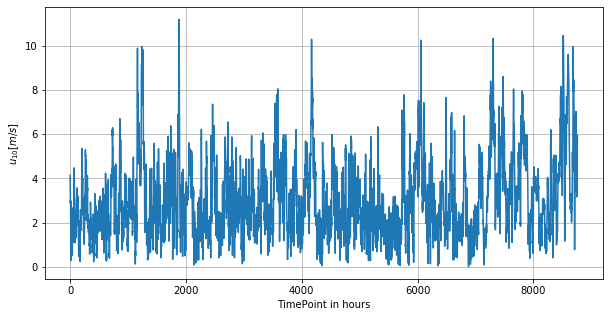

In [78]:
plt.figure(figsize=[10,5])
plt.xlabel('TimePoint in hours')
plt.ylabel('$u_{10}[m/s]$')
plt.grid()
plt.plot(train)

Normalizacja danych:

In [11]:
# add code here
scaler = MinMaxScaler()
scaler.fit(train)

norm_train = scaler.transform(train)
norm_test = scaler.transform(test)

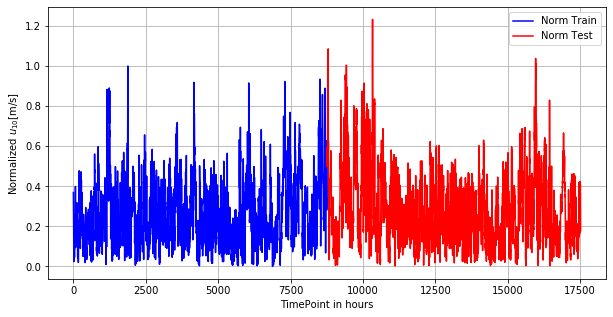

In [80]:
plt.figure(figsize=[10,5])
plt.xlabel('TimePoint in hours')
plt.ylabel('Normalized $u_{10}$[m/s]')
plt.grid()
plt.plot(range(len(train)),norm_train,'b')
plt.plot(range(len(train),len(train)+len(test)),norm_test,'r')
plt.legend(['Norm Train','Norm Test']);

Podział szeregu czasowego na input/output:

In [12]:
def split_X_y(data, look_back = 1, pred_forward = 1):
    dataX, dataY = [], []
    for i in range(len(data)-look_back-pred_forward):
        a = data[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(data[i + look_back + pred_forward -1 , 0])
    return np.array(dataX), np.array(dataY).reshape((len(dataY),1))

In [14]:
# reshape into X contains the data for times t-i ... t-2 t-1 and Y contains the data for times t
look_back = 1 # here we will only look at the previous datapoint to predict the next one
trainX, trainY = split_X_y(norm_train, look_back)
testX, testY = split_X_y(norm_test, look_back)

In [15]:
# # reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [16]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(8758, 1, 1)
(8758, 1)
(8758, 1, 1)
(8758, 1)


Stworzenie i trening modelu LSTM:

In [17]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
8758/8758 - 32s - loss: 0.0058
Epoch 2/20
8758/8758 - 25s - loss: 8.4160e-04
Epoch 3/20
8758/8758 - 25s - loss: 8.3862e-04
Epoch 4/20
8758/8758 - 28s - loss: 8.3601e-04
Epoch 5/20
8758/8758 - 27s - loss: 8.3946e-04
Epoch 6/20
8758/8758 - 27s - loss: 8.3108e-04
Epoch 7/20
8758/8758 - 28s - loss: 8.3643e-04
Epoch 8/20
8758/8758 - 27s - loss: 8.3320e-04
Epoch 9/20
8758/8758 - 27s - loss: 8.3464e-04
Epoch 10/20
8758/8758 - 26s - loss: 8.3996e-04
Epoch 11/20
8758/8758 - 26s - loss: 8.3812e-04
Epoch 12/20
8758/8758 - 26s - loss: 8.3609e-04
Epoch 13/20
8758/8758 - 27s - loss: 8.3510e-04
Epoch 14/20
8758/8758 - 27s - loss: 8.3594e-04
Epoch 15/20
8758/8758 - 26s - loss: 8.3896e-04
Epoch 16/20
8758/8758 - 25s - loss: 8.3217e-04
Epoch 17/20
8758/8758 - 25s - loss: 8.3510e-04
Epoch 18/20
8758/8758 - 25s - loss: 8.3073e-04
Epoch 19/20
8758/8758 - 25s - loss: 8.3847e-04
Epoch 20/20
8758/8758 - 25s - loss: 8.3058e-04


Dokonanie predykcji i wyświetlenie przykładu:

In [18]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainYTrue = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testYTrue = scaler.inverse_transform(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainYTrue, trainPredict))
print('Train Score: %.4f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testYTrue, testPredict))
print('Test Score: %.4f RMSE' % (testScore))

Train Score: 0.4588 RMSE
Test Score: 0.4870 RMSE


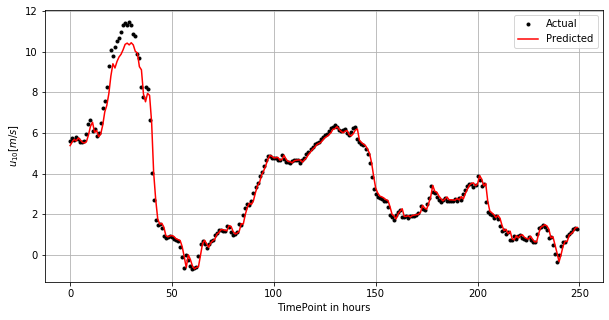

In [20]:
plt.figure(figsize=[10,5])
plt.xlabel('TimePoint in hours')
plt.ylabel('$u_{10}[m/s]$')
plt.grid()
plt.plot(range(250), testYTrue[:250],'k.')
plt.plot(range(250),testPredict[:250],'r')
plt.legend(['Actual','Predicted'])

## Lookback = 6h

In [103]:
# reshape into X contains the data for times t-i ... t-2 t-1 and Y contains the data for times t
look_back = 6 # here we will only look at the previous datapoint to predict the next one
trainX_6h, trainY_6h = split_X_y(norm_train, look_back)
testX_6h, testY_6h = split_X_y(norm_test, look_back)

# # reshape input to be [samples, time steps, features]
trainX_6h = np.reshape(trainX_6h, (trainX_6h.shape[0], 1, trainX_6h.shape[1]))
testX_6h = np.reshape(testX_6h, (testX_6h.shape[0], 1, testX_6h.shape[1]))

print(trainX_6h.shape)
print(trainY_6h.shape)
print(testX_6h.shape)
print(testY_6h.shape)

(8753, 1, 6)
(8753,)
(8753, 1, 6)
(8753,)


In [104]:
# create and fit the LSTM network
model_6h = Sequential()
model_6h.add(LSTM(4, input_shape=(1, look_back)))
model_6h.add(Dense(1))
model_6h.compile(loss='mean_squared_error', optimizer='adam')
model_6h.fit(trainX_6h, trainY_6h, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
8753/8753 - 32s - loss: 0.0051
Epoch 2/20
8753/8753 - 30s - loss: 8.2780e-04
Epoch 3/20
8753/8753 - 29s - loss: 7.7019e-04
Epoch 4/20
8753/8753 - 30s - loss: 7.5007e-04
Epoch 5/20
8753/8753 - 30s - loss: 7.3422e-04
Epoch 6/20
8753/8753 - 26s - loss: 7.2052e-04
Epoch 7/20
8753/8753 - 29s - loss: 7.1783e-04
Epoch 8/20
8753/8753 - 26s - loss: 7.0452e-04
Epoch 9/20
8753/8753 - 27s - loss: 7.0325e-04
Epoch 10/20
8753/8753 - 28s - loss: 7.0163e-04
Epoch 11/20
8753/8753 - 29s - loss: 7.0062e-04
Epoch 12/20
8753/8753 - 27s - loss: 6.9273e-04
Epoch 13/20
8753/8753 - 30s - loss: 6.9736e-04
Epoch 14/20
8753/8753 - 29s - loss: 6.9384e-04
Epoch 15/20
8753/8753 - 30s - loss: 6.9365e-04
Epoch 16/20
8753/8753 - 29s - loss: 6.8643e-04
Epoch 17/20
8753/8753 - 28s - loss: 6.9002e-04
Epoch 18/20
8753/8753 - 28s - loss: 6.8181e-04
Epoch 19/20
8753/8753 - 31s - loss: 6.8789e-04
Epoch 20/20
8753/8753 - 31s - loss: 6.8240e-04


In [109]:
trainY_6h

array([0.46072971, 0.47218958, 0.4668335 , ..., 0.58234782, 0.59804984,
       0.60334488])

In [111]:
# make predictions
trainPredict_6h = model_6h.predict(trainX_6h)
testPredict_6h = model_6h.predict(testX_6h)

# reshape labels
trainY_6h = trainY_6h.reshape((len(trainY_6h), 1))
testY_6h = testY_6h.reshape((len(testY_6h), 1))

# invert predictions
trainPredict_6h = scaler.inverse_transform(trainPredict_6h)
trainYTrue_6h = scaler.inverse_transform(trainY_6h)
testPredict_6h = scaler.inverse_transform(testPredict_6h)
testYTrue_6h = scaler.inverse_transform(testY_6h)

# calculate root mean squared error
trainScore_6h = math.sqrt(mean_squared_error(trainYTrue_6h, trainPredict_6h))
print('Train Score: %.4f RMSE' % (trainScore_6h))
testScore_6h = math.sqrt(mean_squared_error(testYTrue_6h, testPredict_6h))
print('Test Score: %.4f RMSE' % (testScore_6h))

Train Score: 0.4116 RMSE
Test Score: 0.4402 RMSE


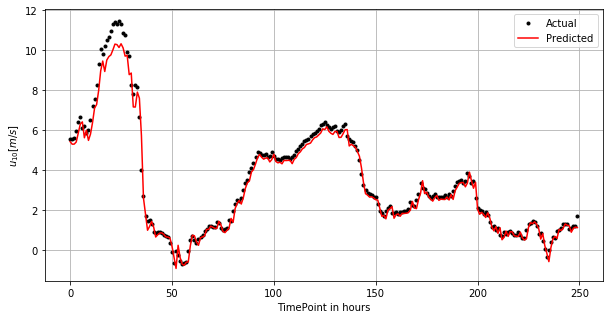

In [127]:
plt.figure(figsize=[10,5])
plt.xlabel('TimePoint in hours')
plt.ylabel('$u_{10}[m/s]$')
plt.grid()
plt.plot(range(250), testYTrue_6h[:250],'k.')
plt.plot(range(250),testPredict_6h[:250],'r')
plt.legend(['Actual','Predicted'])

## Przewidywania na 6h do przodu - lookback = 1:

In [129]:
# reshape into X contains the data for times t-i ... t-2 t-1 and Y contains the data for times t
look_back = 1 # here we will only look at the previous datapoint to predict the next one
forward = 6
trainX_1_6, trainY_1_6 = split_X_y(norm_train, look_back, forward)
testX_1_6, testY_1_6 = split_X_y(norm_test, look_back, forward)

# # reshape input to be [samples, time steps, features]
trainX_1_6 = np.reshape(trainX_1_6, (trainX_1_6.shape[0], 1, trainX_1_6.shape[1]))
testX_1_6 = np.reshape(testX_1_6, (testX_1_6.shape[0], 1, testX_1_6.shape[1]))

print(trainX_1_6.shape)
print(trainY_1_6.shape)
print(testX_1_6.shape)
print(testY_1_6.shape)

(8753, 1, 1)
(8753, 1)
(8753, 1, 1)
(8753, 1)


In [130]:
# create and fit the LSTM network
model_1_6 = Sequential()
model_1_6.add(LSTM(4, input_shape=(1, look_back)))
model_1_6.add(Dense(1))
model_1_6.compile(loss='mean_squared_error', optimizer='adam')
model_1_6.fit(trainX_1_6, trainY_1_6, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
8753/8753 - 27s - loss: 0.0139
Epoch 2/20
8753/8753 - 26s - loss: 0.0087
Epoch 3/20
8753/8753 - 23s - loss: 0.0087
Epoch 4/20
8753/8753 - 23s - loss: 0.0087
Epoch 5/20
8753/8753 - 22s - loss: 0.0087
Epoch 6/20
8753/8753 - 23s - loss: 0.0087
Epoch 7/20
8753/8753 - 22s - loss: 0.0087
Epoch 8/20
8753/8753 - 22s - loss: 0.0087
Epoch 9/20
8753/8753 - 22s - loss: 0.0087
Epoch 10/20
8753/8753 - 22s - loss: 0.0086
Epoch 11/20
8753/8753 - 22s - loss: 0.0087
Epoch 12/20
8753/8753 - 26s - loss: 0.0086
Epoch 13/20
8753/8753 - 27s - loss: 0.0087
Epoch 14/20
8753/8753 - 28s - loss: 0.0087
Epoch 15/20
8753/8753 - 27s - loss: 0.0087
Epoch 16/20
8753/8753 - 27s - loss: 0.0087
Epoch 17/20
8753/8753 - 26s - loss: 0.0087
Epoch 18/20
8753/8753 - 26s - loss: 0.0087
Epoch 19/20
8753/8753 - 27s - loss: 0.0087
Epoch 20/20
8753/8753 - 28s - loss: 0.0087


In [131]:
# make predictions
trainPredict_1_6 = model_1_6.predict(trainX_1_6)
testPredict_1_6 = model_1_6.predict(testX_1_6)

# reshape labels
# trainY_6h = trainY_6h.reshape((len(trainY_6h), 1))
# testY_6h = testY_6h.reshape((len(testY_6h), 1))

# invert predictions
trainPredict_1_6 = scaler.inverse_transform(trainPredict_1_6)
trainYTrue_1_6 = scaler.inverse_transform(trainY_1_6)
testPredict_1_6 = scaler.inverse_transform(testPredict_1_6)
testYTrue_1_6 = scaler.inverse_transform(testY_1_6)

# calculate root mean squared error
trainScore_1_6 = math.sqrt(mean_squared_error(trainYTrue_1_6, trainPredict_1_6))
print('Train Score: %.4f RMSE' % (trainScore_1_6))
testScore_1_6 = math.sqrt(mean_squared_error(testYTrue_1_6, testPredict_1_6))
print('Test Score: %.4f RMSE' % (testScore_1_6))

Train Score: 1.4987 RMSE
Test Score: 1.5597 RMSE


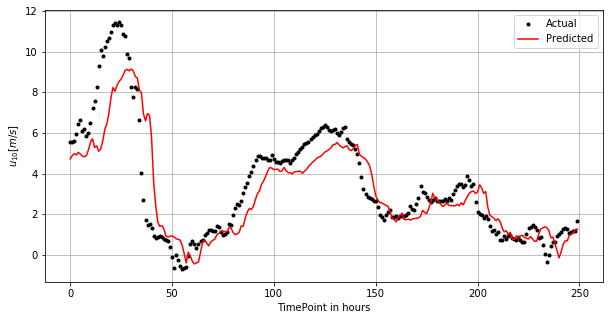

In [141]:
plt.figure(figsize=[10,5])
plt.xlabel('TimePoint in hours')
plt.ylabel('$u_{10}[m/s]$')
plt.grid()
plt.plot(range(250), testYTrue_1_6[:250],'k.')
plt.plot(range(250),testPredict_1_6[:250],'r')
plt.legend(['Actual','Predicted'])

## 6h lookback, 6h w przód:

In [135]:
# reshape into X contains the data for times t-i ... t-2 t-1 and Y contains the data for times t
look_back = 6 # here we will only look at the previous datapoint to predict the next one
forward = 6
trainX_6_6, trainY_6_6 = split_X_y(norm_train, look_back, forward)
testX_6_6, testY_6_6 = split_X_y(norm_test, look_back, forward)

# # reshape input to be [samples, time steps, features]
trainX_6_6 = np.reshape(trainX_6_6, (trainX_6_6.shape[0], 1, trainX_6_6.shape[1]))
testX_6_6 = np.reshape(testX_6_6, (testX_6_6.shape[0], 1, testX_6_6.shape[1]))

print(trainX_6_6.shape)
print(trainY_6_6.shape)
print(testX_6_6.shape)
print(testY_6_6.shape)

(8748, 1, 6)
(8748, 1)
(8748, 1, 6)
(8748, 1)


In [136]:
# create and fit the LSTM network
model_6_6 = Sequential()
model_6_6.add(LSTM(4, input_shape=(1, look_back)))
model_6_6.add(Dense(1))
model_6_6.compile(loss='mean_squared_error', optimizer='adam')
model_6_6.fit(trainX_6_6, trainY_6_6, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
8748/8748 - 31s - loss: 0.0103
Epoch 2/20
8748/8748 - 27s - loss: 0.0090
Epoch 3/20
8748/8748 - 27s - loss: 0.0089
Epoch 4/20
8748/8748 - 29s - loss: 0.0088
Epoch 5/20
8748/8748 - 29s - loss: 0.0087
Epoch 6/20
8748/8748 - 28s - loss: 0.0087
Epoch 7/20
8748/8748 - 29s - loss: 0.0086
Epoch 8/20
8748/8748 - 28s - loss: 0.0086
Epoch 9/20
8748/8748 - 27s - loss: 0.0086
Epoch 10/20
8748/8748 - 29s - loss: 0.0085
Epoch 11/20
8748/8748 - 28s - loss: 0.0086
Epoch 12/20
8748/8748 - 28s - loss: 0.0085
Epoch 13/20
8748/8748 - 29s - loss: 0.0085
Epoch 14/20
8748/8748 - 29s - loss: 0.0085
Epoch 15/20
8748/8748 - 29s - loss: 0.0085
Epoch 16/20
8748/8748 - 30s - loss: 0.0084
Epoch 17/20
8748/8748 - 30s - loss: 0.0085
Epoch 18/20
8748/8748 - 30s - loss: 0.0084
Epoch 19/20
8748/8748 - 29s - loss: 0.0084
Epoch 20/20
8748/8748 - 29s - loss: 0.0084


In [137]:
# make predictions
trainPredict_6_6 = model_6_6.predict(trainX_6_6)
testPredict_6_6 = model_6_6.predict(testX_6_6)

# reshape labels
# trainY_6h = trainY_6h.reshape((len(trainY_6h), 1))
# testY_6h = testY_6h.reshape((len(testY_6h), 1))

# invert predictions
trainPredict_6_6 = scaler.inverse_transform(trainPredict_6_6)
trainYTrue_6_6 = scaler.inverse_transform(trainY_6_6)
testPredict_6_6 = scaler.inverse_transform(testPredict_6_6)
testYTrue_6_6 = scaler.inverse_transform(testY_6_6)

# calculate root mean squared error
trainScore_6_6 = math.sqrt(mean_squared_error(trainYTrue_6_6, trainPredict_6_6))
print('Train Score: %.4f RMSE' % (trainScore_6_6))
testScore_6_6 = math.sqrt(mean_squared_error(testYTrue_6_6, testPredict_6_6))
print('Test Score: %.4f RMSE' % (testScore_6_6))

Train Score: 1.5285 RMSE
Test Score: 1.5732 RMSE


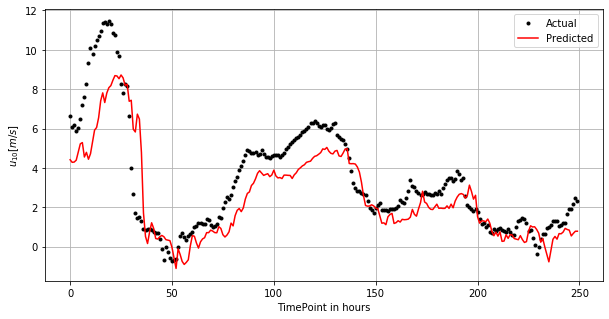

In [138]:
plt.figure(figsize=[10,5])
plt.xlabel('TimePoint in hours')
plt.ylabel('$u_{10}[m/s]$')
plt.grid()
plt.plot(range(250), testYTrue_6_6[:250],'k.')
plt.plot(range(250),testPredict_6_6[:250],'r')
plt.legend(['Actual','Predicted'])

## 24h lookback, 6h w przód

In [123]:
# reshape into X contains the data for times t-i ... t-2 t-1 and Y contains the data for times t
look_back = 24 # here we will only look at the previous datapoint to predict the next one
forward = 6
trainX_24_6, trainY_24_6 = split_X_y(norm_train, look_back, forward)
testX_24_6, testY_24_6 = split_X_y(norm_test, look_back, forward)

# # reshape input to be [samples, time steps, features]
trainX_24_6 = np.reshape(trainX_24_6, (trainX_24_6.shape[0], 1, trainX_24_6.shape[1]))
testX_24_6 = np.reshape(testX_24_6, (testX_24_6.shape[0], 1, testX_24_6.shape[1]))

print(trainX_24_6.shape)
print(trainY_24_6.shape)
print(testX_24_6.shape)
print(testY_24_6.shape)

(8730, 1, 24)
(8730, 1)
(8730, 1, 24)
(8730, 1)


In [124]:
# create and fit the LSTM network
model_24_6 = Sequential()
model_24_6.add(LSTM(4, input_shape=(1, look_back)))
model_24_6.add(Dense(1))
model_24_6.compile(loss='mean_squared_error', optimizer='adam')
model_24_6.fit(trainX_24_6, trainY_24_6, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
273/273 [==============================] - 3s 5ms/step - loss: 0.0224
Epoch 2/20
273/273 [==============================] - 1s 4ms/step - loss: 0.0126
Epoch 3/20
273/273 [==============================] - 1s 5ms/step - loss: 0.0113
Epoch 4/20
273/273 [==============================] - 1s 5ms/step - loss: 0.0105
Epoch 5/20
273/273 [==============================] - 1s 5ms/step - loss: 0.0099
Epoch 6/20
273/273 [==============================] - 1s 5ms/step - loss: 0.0096
Epoch 7/20
273/273 [==============================] - 1s 5ms/step - loss: 0.0093
Epoch 8/20
273/273 [==============================] - 1s 5ms/step - loss: 0.0092
Epoch 9/20
273/273 [==============================] - 1s 5ms/step - loss: 0.0092
Epoch 10/20
273/273 [==============================] - 1s 5ms/step - loss: 0.0091
Epoch 11/20
273/273 [==============================] - 1s 5ms/step - loss: 0.0090
Epoch 12/20
273/273 [==============================] - 1s 5ms/step - loss: 0.0089
Epoch 13/20
273/273 [====

In [125]:
# make predictions
trainPredict_24_6 = model_24_6.predict(trainX_24_6)
testPredict_24_6 = model_24_6.predict(testX_24_6)

# invert predictions
trainPredict_24_6 = scaler.inverse_transform(trainPredict_24_6)
trainYTrue_24_6 = scaler.inverse_transform(trainY_24_6)
testPredict_24_6 = scaler.inverse_transform(testPredict_24_6)
testYTrue_24_6 = scaler.inverse_transform(testY_24_6)

# calculate root mean squared error
trainScore_24_6 = math.sqrt(mean_squared_error(trainYTrue_24_6, trainPredict_24_6))
print('Train Score: %.4f RMSE' % (trainScore_24_6))
testScore_24_6 = math.sqrt(mean_squared_error(testYTrue_24_6, testPredict_24_6))
print('Test Score: %.4f RMSE' % (testScore_24_6))

Train Score: 1.5001 RMSE
Test Score: 1.5706 RMSE


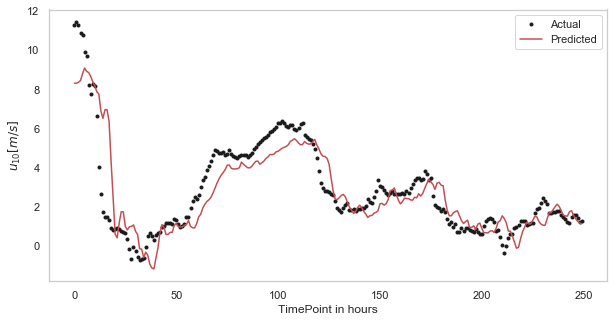

In [126]:
plt.figure(figsize=[10,5])
plt.xlabel('TimePoint in hours')
plt.ylabel('$u_{10}[m/s]$')
plt.grid()
plt.plot(range(250), testYTrue_24_6[:250],'k.')
plt.plot(range(250),testPredict_24_6[:250],'r')
plt.legend(['Actual','Predicted'])

## Bardziej złożone modele (<-24h/6h->):

Dense:

In [13]:
# reshape into X contains the data for times t-i ... t-2 t-1 and Y contains the data for times t
look_back = 24 # here we will only look at the previous datapoint to predict the next one
forward = 6
trainX_24_6, trainY_24_6 = split_X_y(norm_train, look_back, forward)
testX_24_6, testY_24_6 = split_X_y(norm_test, look_back, forward)

# # reshape input to be [samples, time steps, features]
trainX_24_6 = np.reshape(trainX_24_6, (trainX_24_6.shape[0], 1, trainX_24_6.shape[1]))
testX_24_6 = np.reshape(testX_24_6, (testX_24_6.shape[0], 1, testX_24_6.shape[1]))

print(trainX_24_6.shape)
print(trainY_24_6.shape)
print(testX_24_6.shape)
print(testY_24_6.shape)

(8730, 1, 24)
(8730, 1)
(8730, 1, 24)
(8730, 1)


In [17]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=2, mode='min')

model_24_6_dense = Sequential()
model_24_6_dense.add(Dense(24, input_shape=(1, look_back), activation='relu'))
# model_24_6_dense.add(Dropout(0.5))
model_24_6_dense.add(Dense(24, activation='relu'))
model_24_6_dense.add(Dense(24, activation='relu'))
model_24_6_dense.add(Dense(1))
model_24_6_dense.add(Reshape([1]))
model_24_6_dense.compile(loss='mean_squared_error', optimizer='adam')

model_24_6_dense.fit(trainX_24_6, trainY_24_6, epochs=20, batch_size=32, verbose=1, callbacks=[early_stopping])

Epoch 1/20
273/273 [==============================] - 3s 8ms/step - loss: 0.0169
Epoch 2/20
273/273 [==============================] - 2s 8ms/step - loss: 0.0115
Epoch 3/20
273/273 [==============================] - 2s 7ms/step - loss: 0.0113
Epoch 4/20
273/273 [==============================] - 2s 7ms/step - loss: 0.0111
Epoch 5/20
273/273 [==============================] - 2s 7ms/step - loss: 0.0110
Epoch 6/20
273/273 [==============================] - 2s 7ms/step - loss: 0.0110
Epoch 7/20
273/273 [==============================] - 2s 6ms/step - loss: 0.0108
Epoch 8/20
273/273 [==============================] - 2s 8ms/step - loss: 0.0107
Epoch 9/20
273/273 [==============================] - 2s 6ms/step - loss: 0.0107
Epoch 10/20
273/273 [==============================] - 2s 7ms/step - loss: 0.0107
Epoch 11/20
273/273 [==============================] - 2s 7ms/step - loss: 0.0105
Epoch 12/20
273/273 [==============================] - 2s 6ms/step - loss: 0.0106
Epoch 13/20
273/273 [====

In [27]:
# make predictions
trainPredict_24_6 = model_24_6_dense.predict(trainX_24_6)
testPredict_24_6 = model_24_6_dense.predict(testX_24_6)

# invert predictions
trainPredict_24_6 = scaler.inverse_transform(trainPredict_24_6)
trainYTrue_24_6 = scaler.inverse_transform(trainY_24_6)
testPredict_24_6 = scaler.inverse_transform(testPredict_24_6)
testYTrue_24_6 = scaler.inverse_transform(testY_24_6)

# calculate root mean squared error
trainScore_24_6 = math.sqrt(mean_squared_error(trainYTrue_24_6, trainPredict_24_6))
print('Train Score: %.4f RMSE' % (trainScore_24_6))
testScore_24_6 = math.sqrt(mean_squared_error(testYTrue_24_6, testPredict_24_6))
print('Test Score: %.4f RMSE' % (testScore_24_6))

Train Score: 1.1315 RMSE
Test Score: 1.2029 RMSE


Text(0.5, 1.0, 'Sample predictions - dense model')

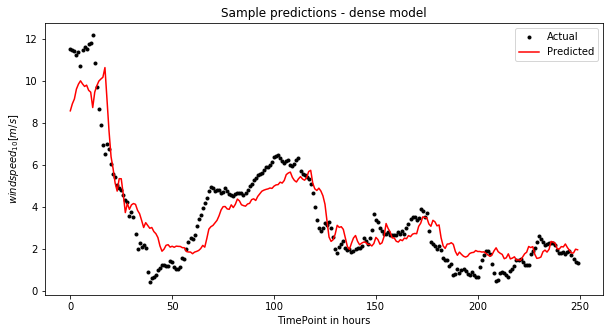

In [28]:
plt.figure(figsize=[10,5])
plt.xlabel('TimePoint in hours')
plt.ylabel('$windspeed_{10}[m/s]$')
# plt.grid()
plt.plot(range(250), testYTrue_24_6[:250],'k.')
plt.plot(range(250),testPredict_24_6[:250],'r')
plt.legend(['Actual','Predicted'])
plt.title("Sample predictions - dense model")

## LSTM

In [20]:
model_24_6_lstm = Sequential()
model_24_6_lstm.add(LSTM(24, input_shape=(1, look_back), return_sequences=True))
# model_24_6_lstm.add(Dropout(0.5))
model_24_6_lstm.add(LSTM(24, return_sequences=True))
# model_24_6_lstm.add(Dropout(0.5))
model_24_6_lstm.add(LSTM(24))
# model_24_6_lstm.add(Dropout(0.5))
model_24_6_lstm.add(Dense(1))
model_24_6_lstm.compile(loss='mean_squared_error', optimizer='adam')
model_24_6_lstm.fit(trainX_24_6, trainY_24_6, epochs=20, batch_size=32, verbose=1, callbacks=[early_stopping])

Epoch 1/20
273/273 [==============================] - 10s 9ms/step - loss: 0.0215
Epoch 2/20
273/273 [==============================] - 2s 9ms/step - loss: 0.0121
Epoch 3/20
273/273 [==============================] - 3s 9ms/step - loss: 0.0114
Epoch 4/20
273/273 [==============================] - 3s 10ms/step - loss: 0.0113
Epoch 5/20
273/273 [==============================] - 3s 9ms/step - loss: 0.0111
Epoch 6/20
273/273 [==============================] - 3s 10ms/step - loss: 0.0111
Epoch 7/20
273/273 [==============================] - 3s 9ms/step - loss: 0.0110
Epoch 8/20
273/273 [==============================] - 3s 9ms/step - loss: 0.0109
Epoch 9/20
273/273 [==============================] - 3s 9ms/step - loss: 0.0109
Epoch 10/20
273/273 [==============================] - 3s 9ms/step - loss: 0.0108
Epoch 11/20
273/273 [==============================] - 2s 9ms/step - loss: 0.0109
Epoch 12/20
273/273 [==============================] - 2s 9ms/step - loss: 0.0108
Epoch 13/20
273/273 [=

In [29]:
# make predictions
trainPredict_24_6 = model_24_6_lstm.predict(trainX_24_6)
testPredict_24_6 = model_24_6_lstm.predict(testX_24_6)

# invert predictions
trainPredict_24_6 = scaler.inverse_transform(trainPredict_24_6)
trainYTrue_24_6 = scaler.inverse_transform(trainY_24_6)
testPredict_24_6 = scaler.inverse_transform(testPredict_24_6)
testYTrue_24_6 = scaler.inverse_transform(testY_24_6)

# calculate root mean squared error
trainScore_24_6 = math.sqrt(mean_squared_error(trainYTrue_24_6, trainPredict_24_6))
print('Train Score: %.4f RMSE' % (trainScore_24_6))
testScore_24_6 = math.sqrt(mean_squared_error(testYTrue_24_6, testPredict_24_6))
print('Test Score: %.4f RMSE' % (testScore_24_6))

Train Score: 1.1574 RMSE
Test Score: 1.2134 RMSE


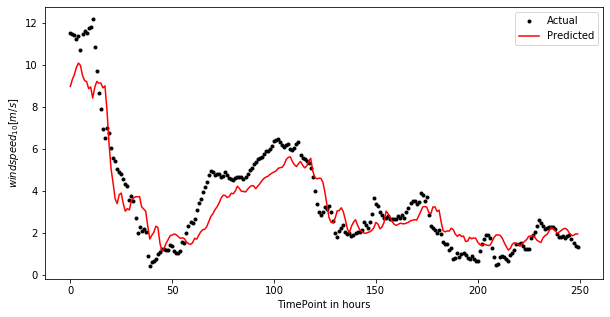

In [22]:
plt.figure(figsize=[10,5])
plt.xlabel('TimePoint in hours')
plt.ylabel('$windspeed_{10}[m/s]$')
# plt.grid()
plt.plot(range(250), testYTrue_24_6[:250],'k.')
plt.plot(range(250),testPredict_24_6[:250],'r')
plt.legend(['Actual','Predicted'])

## GRU

In [89]:
from tensorflow import keras
model_24_6_gru = Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=1, strides=2, padding="valid",
                        input_shape=[1, look_back]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Reshape([1])
])

In [90]:
model_24_6_gru.compile(loss='mean_squared_error', optimizer='adam')
model_24_6_gru.fit(trainX_24_6, trainY_24_6, epochs=20, batch_size=32, verbose=1, callbacks=[early_stopping])

Epoch 1/20
273/273 [==============================] - 10s 8ms/step - loss: 0.0142: 0s - 
Epoch 2/20
273/273 [==============================] - 2s 8ms/step - loss: 0.0118
Epoch 3/20
273/273 [==============================] - 2s 8ms/step - loss: 0.0114
Epoch 4/20
273/273 [==============================] - 2s 8ms/step - loss: 0.0112
Epoch 5/20
273/273 [==============================] - 2s 8ms/step - loss: 0.0109
Epoch 6/20
273/273 [==============================] - 2s 8ms/step - loss: 0.0108
Epoch 7/20
273/273 [==============================] - 2s 8ms/step - loss: 0.0109
Epoch 8/20
273/273 [==============================] - 2s 9ms/step - loss: 0.0109


In [92]:
# make predictions
trainPredict_24_6 = model_24_6_gru.predict(trainX_24_6)
testPredict_24_6 = model_24_6_gru.predict(testX_24_6)

# invert predictions
trainPredict_24_6 = scaler.inverse_transform(trainPredict_24_6)
trainYTrue_24_6 = scaler.inverse_transform(trainY_24_6)
testPredict_24_6 = scaler.inverse_transform(testPredict_24_6)
testYTrue_24_6 = scaler.inverse_transform(testY_24_6)

# calculate root mean squared error
trainScore_24_6 = math.sqrt(mean_squared_error(trainYTrue_24_6, trainPredict_24_6))
print('Train Score: %.4f RMSE' % (trainScore_24_6))
testScore_24_6 = math.sqrt(mean_squared_error(testYTrue_24_6, testPredict_24_6))
print('Test Score: %.4f RMSE' % (testScore_24_6))

Train Score: 1.1489 RMSE
Test Score: 1.1969 RMSE


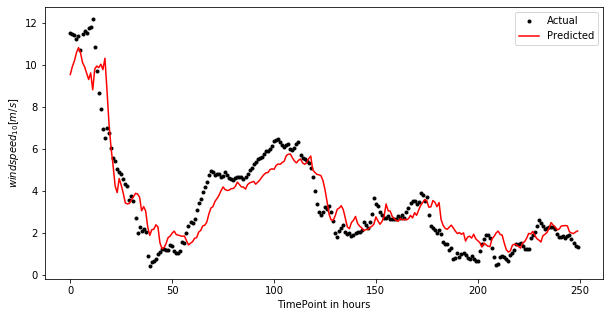

In [93]:
plt.figure(figsize=[10,5])
plt.xlabel('TimePoint in hours')
plt.ylabel('$windspeed_{10}[m/s]$')
# plt.grid()
plt.plot(range(250), testYTrue_24_6[:250],'k.')
plt.plot(range(250),testPredict_24_6[:250],'r')
plt.legend(['Actual','Predicted'])

## Inne okresy testowe:

Preparing data:

In [23]:
years = range(2002,2020)
years = [str(x) for x in years]

datas = []
for year in years:
    test = df[df['Date Time']>=(year+'-01-01')]
    test = test[test['Date Time']<(str(int(year)+1)+'-01-01')]
    test = test['windspeed_10'].values
    test = test.reshape((len(test),1))
    datas.append(test)

Xs = []
ys = []
look_back = 24
forward = 6

for data in datas:
    data = scaler.transform(data)
    X, Y = split_X_y(data, look_back, forward)
    X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
    Xs.append(X)
    ys.append(Y)

In [65]:
# def mean_baseline(X):
#     Y = []
#     for item in X:
#         Y.append(np.mean(item[0]))
#     Y = np.array(Y).reshape(len(Y),1)
#     return Y

# def last_baseline(X):
#     Y = []
#     for item in X:
#         Y.append(item[0][-1])
#     Y = np.array(Y).reshape(len(Y),1)
#     return Y

class mean_baseline():
    def predict(X):
        Y = []
        for item in X:
            Y.append(np.mean(item))
        Y = np.array(Y).reshape(len(Y),1)
        return Y

class last_baseline():
    def predict(X):
        Y = []
        for item in X:
            Y.append(item[0][-1])
        Y = np.array(Y).reshape(len(Y),1)
        return Y

mean = mean_baseline
last = last_baseline

Text(0.5, 0, 'RMSE for years 2002-2020')

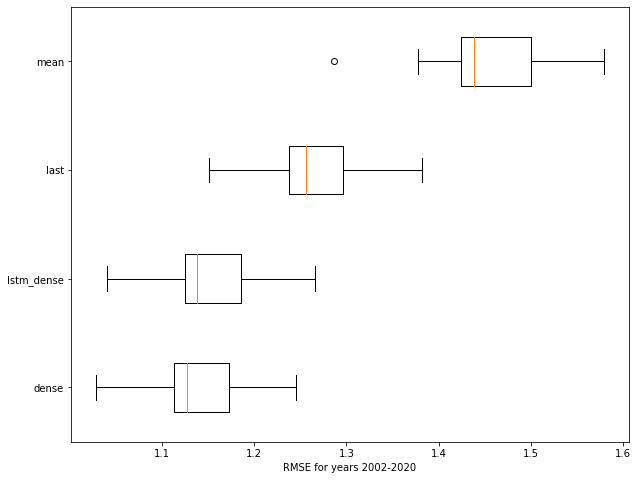

In [66]:
models = {
    "dense":model_24_6_dense, 
    "lstm_dense":model_24_6_lstm,
    "last": last,
    "mean": mean 
}
scores = {}
for key, model in models.items():
    rmses = []
    for i in range(len(years)):
        pred = model.predict(Xs[i])
        pred = scaler.inverse_transform(pred)
        y_true = scaler.inverse_transform(ys[i])
        rmse = math.sqrt(mean_squared_error(y_true, pred))
        rmses.append(rmse)
    scores[key] = rmses

# rmses = []
# for i in range(len(years)):
#     pred = mean_baseline(Xs[i])
#     pred = scaler.inverse_transform(pred)
#     y_true = scaler.inverse_transform(ys[i])
#     rmse = math.sqrt(mean_squared_error(y_true, pred))
#     rmses.append(rmse)
# scores['mean_24h'] = rmses

# rmses = []
# for i in range(len(years)):
#     pred = last_baseline(Xs[i])
#     pred = scaler.inverse_transform(pred)
#     y_true = scaler.inverse_transform(ys[i])
#     rmse = math.sqrt(mean_squared_error(y_true, pred))
#     rmses.append(rmse)
# scores['last'] = rmses

plt.figure(figsize=(10,8))
plt.boxplot(scores.values(), vert=False, labels=scores.keys())
plt.xlabel("RMSE for years 2002-2020")